<a href="https://colab.research.google.com/github/hanyoseob/lecture_optimization/blob/main/chapter09_Newton's_method_for_CT_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method)
---
>In numerical analysis, ___Newton's method___, also known as the ___Newton–Raphson method___, named after Isaac Newton and Joseph Raphson, is __a root-finding algorithm__ which produces successively better approximations to the roots (or zeroes) of a real-valued function. The most basic version starts with a single-variable function $f$ defined for a real variable $x$, the function's derivative $f'$, and an initial guess $x_0$ for a root of $f$.
>
>>![newton's method](https://upload.wikimedia.org/wikipedia/commons/d/da/Newton_optimization_vs_grad_descent.svg "")
>>__[FIGURE] A comparison of [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) (green) and [Newton's method]((https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)) (red) for minimizing a function (with small step sizes). Newton's method uses curvature information (i.e. the second derivative) to take a more direct route.__
>
>__Before following an implementation below, PLEASE REVIEW MATHMETICAL DSCRIPTION[$^{[1]}$](https://en.wikipedia.org/wiki/Newton%27s_method)$^,$ [$^{[2]}$](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) since the more details are described HERE[$^{[1]}$](https://en.wikipedia.org/wiki/Newton%27s_method)$^,$ [$^{[2]}$](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization).__

---
In [the previous chapter](https://colab.research.google.com/drive/1vmWY0pd3ymJDLyQktbGIBtojrXrEK5ES?usp=sharing), I covered a ___deblurring problem___ (called ___image enhancement___) which is one of the natural image tasks and implemented the super-resolution method to enhance the image details collapsed by Gaussian kernel.

Here, we will cover a medical imaging processing and specifically implement a CT reconstruction method using [the Newton's Method](https://en.wikipedia.org/wiki/Newton%27s_method).

Its optimization problem is formulated as:

> $x^* = \arg \min_{x} F(x)$,

where a fidelity term $F(x)$ is defined as $\frac{1}{2} || Ax - y ||_2^2$, a system matrix $A$ denotes [Radon transform](https://en.wikipedia.org/wiki/Radon_transform) ( = projection operation ), $y$ is sinogram measured from the system matrix $A$, and $x$ is a reconstructed image.

In the optimization problem above, since $F(x) = \frac{1}{2} || Ax - y ||_2^2$ is a convex function, the optimal solution $x^*$ is the point $x$ where its derivative $\nabla F(x)= A^T(Ax - y)$ satisfies zero. In terms of [the newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), $f(x)$ which is the function trying to find the roots ( or zeros ), can be formulated by the derivative $\nabla F(x)= A^T(Ax - y)$. Therefore, $f'(x)$ is defined as $A^TA$.

Importantly, except for the system matrix $A$ such as the Gaussian kernel that handles ___natural image processing___ and the projection operation that handles ___medical image processing___, both problems can be solved without changing the optimization problem. In other words, regardless of the domains such as natural image and medical image, the solution of the inverse problem can be found by solving the optimization problem if we know the system matrix $A$ and its transpose matrix $A^T$.

Specifically, we need to define a transopose operator $A^T$ of the 2D convolution operation. The answer that ___How to define the transpose operator of the function___ is described [MY OTHER LECTURE](https://www.youtube.com/watch?v=erdPhFEoFYc). Please watch [THE LECTURE](https://www.youtube.com/watch?v=erdPhFEoFYc) before starting the example.

## General solution
---
> $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$,

where $f(\cdot)$ and $f'(\cdot)$ are the function trying to find the roots ( or zeros ) and its derivative, respectively.


# Implementation
---

1. Problem definition
7. Implement the newton's method to reconstruct computed tomography (CT)

## Step 1. Problem definition

1. Objective function $F(x)$
> $F(x) = \frac{1}{2} || Ax - y ||_2^2$

2. the function trying to find the roots $f(x)$ ( = its derivative $\nabla F(x)$ )
> $f(x) = \nabla F(x)$
>
> $~~~~~~~= A^T(Ax - y)$

3. its derivative $f'(x)$
> $f'(x) = A^TA$

3. Global solution

  > $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$,

  > $x_{n+1} = x_n - \frac{A^T(Ax_n - y)}{A^TA}$


## Step 2. Newton's method

1. Add packages
2. Set the system matrix $A$ and its [transpose](https://en.wikipedia.org/wiki/Transpose) $A^T$
3. Run the [inverse radon transform](https://en.wikipedia.org/wiki/Radon_transform) $A^{-1}$
4. Set the parameters of the Newton's method
5. Run the Newton's method

### Add packages

In [ ]:
# Mathmetical packages
import numpy as np
from scipy.signal import convolve

# Image processing package
from skimage import data
from skimage.transform import resize

# CT processing package
from skimage.transform import radon, iradon

# Metrics calculating packages
from skimage.metrics import normalized_root_mse as compare_nmse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ploting packages
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# Ploting options
font = {'family': 'normal',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)


### Set the system matrix $A$ and its transpose $A^T$

__If you are not familiar with the concept of the transpose, please check out [my lecture video related to transpose](https://www.youtube.com/watch?v=erdPhFEoFYc) and [wikipedia](https://en.wikipedia.org/wiki/Transpose).__ 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


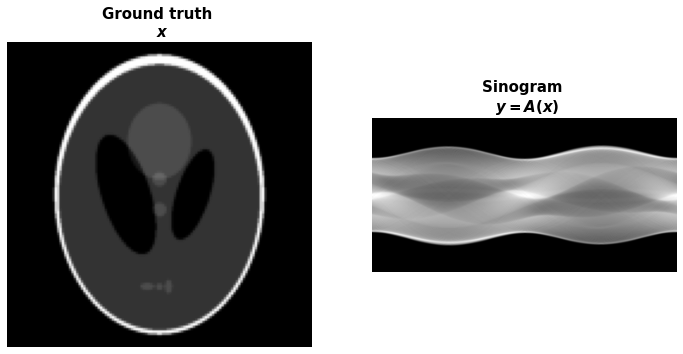

In [ ]:
# Load the clean image x ( = ground truth ) 
N = 128   # size of image

# Shepp logan phantom is a default phantom in the CT field
x_gt = data.shepp_logan_phantom().astype(dtype=np.float64)
x_gt = resize(x_gt, output_shape=(N, N))

# Set the CT system parameters
VIEW = 360
THETA = np.linspace(0, 360, VIEW, endpoint=False)

# Define the System operator (A) and its transpose (AT)
# A: Projection operation ( = radon transform )
# AT: Backprojection operation without the filtration ( = iradon transform w\o filtration )
A = lambda x: radon(x, theta=THETA, circle=False)
AT = lambda y: iradon(y, theta=THETA, circle=False, output_size=N, filter=None) / (np.pi / (2.0 * VIEW))

DCT = A(np.zeros_like(x_gt)).shape[0]

# Generate the output y from the system operator A
y = A(x_gt)

# Plot the images
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))

axs[0].imshow(x_gt, vmin=0, vmax=1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Ground truth \n $x$', fontsize=15, fontweight='bold')

axs[1].imshow(y, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Sinogram \n $y = A(x)$', fontsize=15, fontweight='bold')

plt.show()


### Run the inverse radon transform ( = Filtered Backprojection; FBP ) $A^{-1}$

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


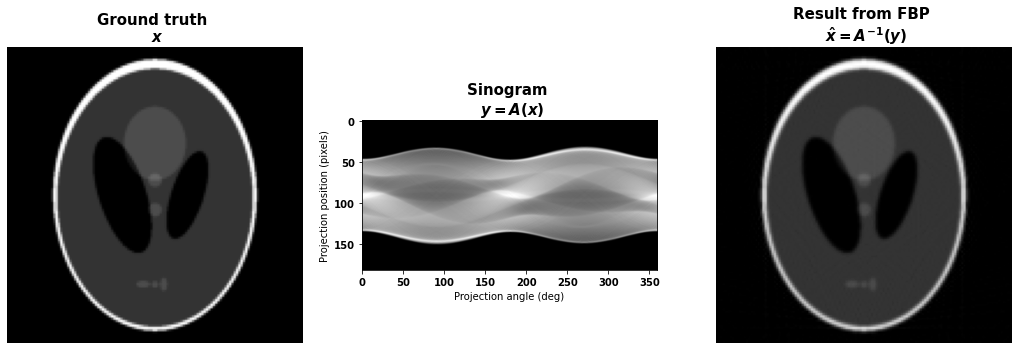

Result from Filtered Backprojection
NSME: 1.3676e-01
PSNR: 29.9304
SSIM: 0.9806


In [ ]:
# A^-1: Filtered Backprojection (FBP) operation ( = iradon transform )
AINV = lambda y: iradon(y, theta=THETA, circle=False, output_size=N, filter='ramp')

# Filtered Backprojection (FBP)
x = AINV(y)

# Plot the images
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 8))

ax = axs[0]
ax.imshow(x_gt, vmin=0, vmax=1, cmap='gray')
ax.set_title('Ground truth \n $x$', fontsize=15, fontweight='bold')
ax.axis('off')

ax = axs[1]
ax.imshow(y, cmap='gray')
ax.set_title('Sinogram \n $y = A(x)$', fontsize=15, fontweight='bold')
ax.set_xlabel("Projection angle (deg)")
ax.set_ylabel("Projection position (pixels)")
# axs[1].axis('off')

ax = axs[2]
ax.imshow(x, vmin=0, vmax=1, cmap='gray')
ax.set_title('Result from FBP \n $\hat{x} = A^{-1}(y)$', fontsize=15, fontweight='bold')
ax.axis('off')

plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_est_fbp = x

nmse_fbp = compare_nmse(x_gt, x_est_fbp)
psnr_fbp = compare_psnr(x_gt, x_est_fbp)
ssim_fbp = compare_ssim(x_gt, x_est_fbp)

print('Result from Filtered Backprojection')
print('NSME: %.4e' % nmse_fbp)
print('PSNR: %.4f' % psnr_fbp)
print('SSIM: %.4f' % ssim_fbp)

### Set the parameters of the newton's method

In [ ]:
# F: Objective function

# f: The function trying to find the roots ( or zeros ) ( = dF )
# df: Its derivative

F = lambda x: 1/2 * np.sum( (A(x) - y) ** 2 )
f = lambda x: AT( A(x) - y )
df = lambda x: AT( A(np.ones_like(x)) )

# Hyper parameters for the gradient descent method
max_iter = 300
step_size = 1e-1


### Run the newton's method

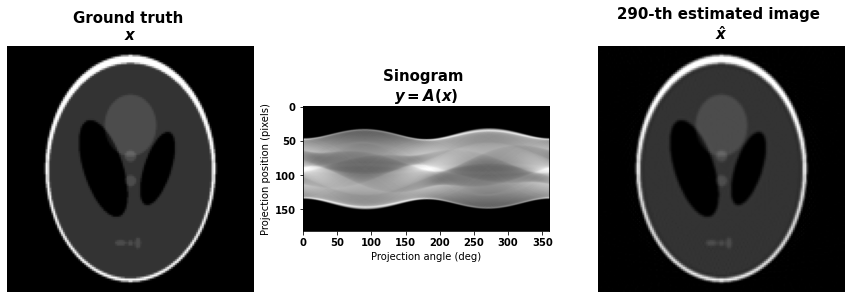

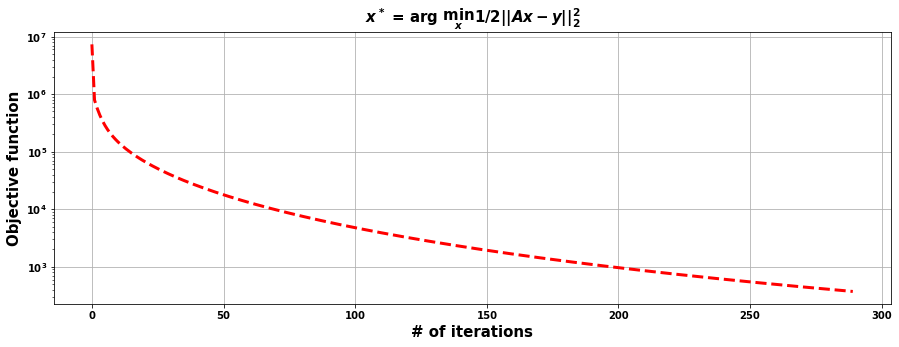

In [ ]:
x = np.zeros((N, N))
dfx = df(x)

x_iter = []
y_iter = []

x_iter.append(x)
y_iter.append(F(x))

for i in range(1, max_iter + 1):

  # Newton's method
  x = x - f(x) / dfx

  x_iter.append(x)
  y_iter.append(F(x))

  # Plot the results from gradient descent method
  if ((i + 1) % 10) == 0 or (i + 1) == max_iter:
    # Plot the images from ground truth, gradient descent method, and difference map.
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    ax = axs[0]
    pcm = ax.imshow(x_gt, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Ground truth \n$x$', fontsize=15, fontweight='bold')
    ax.axis('off')
    # fig.colorbar(pcm, ax=ax)

    ax = axs[1]
    pcm = ax.imshow(y, cmap='gray')
    ax.set_title('Sinogram \n$y = A(x)$', fontsize=15, fontweight='bold')
    ax.set_xlabel("Projection angle (deg)")
    ax.set_ylabel("Projection position (pixels)")
    # fig.colorbar(pcm, ax=ax)

    ax = axs[2]
    pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
    ax.set_title('%d-th estimated image \n$\hat{x}$' % (i + 1), fontsize=15, fontweight='bold')
    ax.axis('off')
    # fig.colorbar(pcm, ax=ax)

    # Plot a curve of the objective function
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

    axs.semilogy(y_iter, 'r--', linewidth=3)
    axs.grid(True)
    axs.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
    axs.set_ylabel('Objective function', fontsize=15, fontweight='bold')
    axs.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

    display.clear_output(wait=True)
    plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_est_newton = x

nmse_newton = compare_nmse(x_gt, x_est_newton)
psnr_newton = compare_psnr(x_gt, x_est_newton)
ssim_newton = compare_ssim(x_gt, x_est_newton)

print('Result from Newton\'s method')
print('NSME: %.4e' % nmse_newton)
print('PSNR: %.4f' % psnr_newton)
print('SSIM: %.4f' % ssim_newton)

# Conclusion

In this chapter, we covered ___the CT reconstruction problem___, which is one of the medical image processing. Below figure shows the results from [Filtered Backprojection (FBP)](https://en.wikipedia.org/wiki/Radon_transform) and [the newton's method](https://en.wikipedia.org/wiki/Newton%27s_method). Since it is a noise-free CT system, its FBP result shows the exact reconstructed image. However, the results are destorted if the system collapses by low-dose, sparse-view, and truncated detectors. In this case, the FBP method can not provide high-quality reconstructed results, so we need to consider an optimization method with constraints such as total variation (TV) and low-rankness penalties.

In [ ]:
# Plot the results
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))

ax = axs[0, 0]
pcm = ax.imshow(x_gt, cmap='gray', vmin=0, vmax=1)
ax.set_title('Ground truth \n$x$', fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[0, 1]
pcm = ax.imshow(x_est_fbp, cmap='gray', vmin=0, vmax=1)
ax.set_title('Result from FBP \n NMSE = %.4e' % (nmse_fbp), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[0, 2]
pcm = ax.imshow(x_est_newton, cmap='gray', vmin=0, vmax=1)
ax.set_title('Result from Newton\'s method \n NMSE = %.4e' % (nmse_newton), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[1, 0]
pcm = ax.imshow(y, cmap='gray')
ax.set_title('Sinogram \n$y=A(x)$', fontsize=15, fontweight='bold')
ax.set_xlabel("Projection angle (deg)")
ax.set_ylabel("Projection position (pixels)")
# ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[1, 1]
pcm = ax.imshow(x_gt - x_est_fbp, cmap='gray', vmin=-0.5, vmax=+0.5)
ax.set_title('Difference map \n from FBP ', fontsize=15, fontweight='bold')
ax.axis('off')
fig.colorbar(pcm, ax=ax)

ax = axs[1, 2]
pcm = ax.imshow(x_gt - x_est_newton, cmap='gray', vmin=-0.5, vmax=+0.5)
ax.set_title('Difference map \n from Newton\'s method', fontsize=15, fontweight='bold')
ax.axis('off')
fig.colorbar(pcm, ax=ax)

plt.show()

# Print the quantitative metrics
print(' ')
print('Quantitative metrics')
print(' ')

print('Normalized Mean Sqaure Error (NMSE)')
print('Filtered Backprojection: %.4e' % nmse_fbp)
print('Newton\'s method        : %.4e' % nmse_newton)
print(' ')

print('Peak Signal to Noise Ratio (PSNR)')
print('Filtered Backprojection: %.4f' % psnr_fbp)
print('Newton\'s method        : %.4f' % psnr_newton)
print(' ')

print('Structural Similarity Index Measure (SSIM)')
print('Filtered Backprojection: %.4f' % ssim_fbp)
print('Newton\'s method        : %.4f' % ssim_newton)
print(' ')

#References
---

1. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
2. [Newton's method in optimization](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization)
3. [Radon transfrom](https://en.wikipedia.org/wiki/Radon_transform)

# Next
---

Next chapter, we will cover the [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) which is one of the optimization solvers.